<a href="https://colab.research.google.com/github/LouisLortie/colab/blob/main/ecse_551_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#@title Import list

# from google.colab import drive                    # Need to activate this if using Google Colab (with drive)
import csv
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [21]:
#@title Load CSV

# drive.mount('/content/drive')                    # Activate on drive
# Reading air quality data
# aq_csv = pd.read_csv("/content/drive/MyDrive/ecse_551/assignment1/air_quality.csv")                 # Active on drive
aq_csv = pd.read_csv("air_quality.csv") 

# Reading liver patient data
# lp_csv = pd.read_csv("/content/drive/MyDrive/ecse_551/assignment1/liver_patient.csv")               # Active on drive
lp_csv = pd.read_csv("liver_patient.csv") 

# Array
aq_data = np.array(aq_csv)
lp_data = np.array(lp_csv)

In [13]:
#@title Setting rcParams
plt.style.use('classic')
plt.rcParams.update({
                        #  "text.usetex": True,
                        #  "font.family": "serif",
                        #  "font.sans-serif": ["Times"],
                         "lines.linewidth" : 3,
                         "font.size" : 12,
                         "figure.constrained_layout.use" : True,
                         "hist.bins" : 100 
                         })

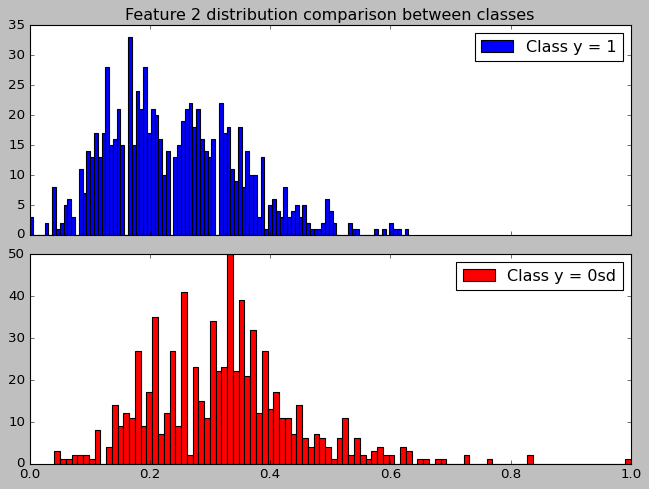

In [20]:
#@title Main function
def main():

  feat = 1   # Feature to analyse.

  data_pos, data_neg = data_separation(aq_data)
  
  plot_hist(data_pos[:, feat], data_neg[:, feat], feat)

  
  
if __name__ == '__main__':
    main()

In [17]:
# Function that classifies the training data into the two binary classes
def data_separation(data):

  count_pos = 0
  count_neg = 0
  
  for i in range(data.shape[0]) :      # all rows of data

    if data[i, -1] == 0 :
      if count_neg == 0 :
        data_neg = data[[i], :]
      else :
        data_neg = np.concatenate((data_neg, data[[i], :]), axis=0)
      count_neg += 1

    elif data[i, -1] == 1 :
      if count_pos == 0 :
        data_pos = data[[i], :]
      else :
        data_pos = np.concatenate((data_pos, data[[i], :]), axis=0)
      count_pos += 1

  return data_pos, data_neg

In [16]:
# Function that counts the number of features
def feature_count(data):
  return data.shape[1] - 1         # The last column is the class label

In [19]:
# Function that plots the histogram of one feature. The number of bins can be changed via rcParams above.
def plot_hist(feat_pos, feat_neg, feat_num):
  fig, ax = plt.subplots(2, 1, sharex=True)
  ax[0].hist(feat_pos, color="b", label=r"Class y = 1")
  ax[1].hist(feat_neg, color="r", label=r"Class y = 0")
  ax[0].set_title("Feature %i distribution comparison between classes" %(feat_num + 1))
  ax[0].legend(loc='upper right')
  ax[1].legend(loc='upper right')
  plt.tight_layout

  return 0